In [1]:
# importing libraries

from keras.layers import Input, Dense, GaussianNoise, Lambda
from keras.models import Model  
from keras.layers import ActivityRegularization
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD

from keras import backend as K
import numpy as np 
import random as rd
import matplotlib.pyplot as plt 

In [2]:
# Initialization - Autoencoder (n,k)
# M: number of messages to encode
# k = log2(M)
# n real-value signals (otherwise. for complex-valued signals, 2*n real numbers)
k = 4
n = 7
M = 2**k
R = k/n

#print('M:',M,'\t','k:',k,'\t','n:',n)

In [3]:
# Channel parameters
Eb_No_dB = 7
noise = 1/(10**(Eb_No_dB/10))
noise_sigma = np.sqrt(noise)
beta = 1/(2*R*(10**(Eb_No_dB/10)))
beta_sqrt = np.sqrt(beta)

In [4]:
# Creating a training set and test set 
eye_matrix = np.eye(M)
x_train = np.tile(eye_matrix, (1000, 1))  
x_test = np.tile(eye_matrix, (100, 1)) 
rd.shuffle(x_train)
rd.shuffle(x_test)

In [5]:
# Printing the shape of x_train and x_test
print(x_train.shape)  
print(x_test.shape) 

(16000, 16)
(1600, 16)


In [6]:
#Bit Error Rate
def BER(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)), axis=-1)  

<h4>Autoencoder definition & construction</h4>

In [7]:
# Take the input and convert it to Keras tensors
input_signal = Input(shape=(M,))
encoded_input = Input(shape=(n,))

<h5>Transmitter Neural Network (encoder)</h5>

In [8]:
######## YOUR CODE STARTS HERE #######
# first layer, with ReLU activation
l1_out = Dense(M, activation='relu')(input_signal)

# second layer, with linear activation
encoded = Dense(n, activation='linear')(l1_out)
######## END OF YOUR CODE      #######

#encoded = Dense(n, activation='linear')(input_signal)


# If you want to use regularizers or perform batch normalization, uncomment the below 
#encoded = ActivityRegularization(l2=0.02)(encoded)
#encoded = BatchNormalization()(encoded)

<h5>Signal constraints</h5>

In [9]:
encoded = Lambda(lambda x: np.sqrt(n) * K.l2_normalize(x, axis=1))(encoded) #fixed energy constraint
######## YOUR CODE STARTS HERE #######
#encoded = Lambda(lambda x: x / K.sqrt(K.mean(x**2)))(encoded) #average power constraint
######## END OF YOUR CODE      #######

<h5>Channel Layer</h5>

In [10]:
encoded_noise = GaussianNoise(beta_sqrt)(encoded)

<h5>Receiver Neural Network (decoder)</h5>

In [11]:
######## YOUR CODE STARTS HERE #######
# first layer, with ReLU activation
l_out = Dense(M, activation='relu')(encoded_noise)

# second layer, with softmax activation
decoded = Dense(M, activation='softmax')(l_out)
######## END OF YOUR CODE      #######

#decoded = Dense(M, activation='softmax')(encoded_noise)

<h5>Computation</h5>

In [12]:
# We create the autoencoder with input_signal as the input and output being the final decoder layer
autoencoder = Model(inputs=input_signal, outputs=decoded)  


# We extract the encoder that takes the input_signal as the input and the output of the encoder is the encoded signal
encoder = Model(inputs=input_signal, outputs=encoded)


# To show the structure of the deep autoencodder (layers, trainable parameters,...)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 119       
_________________________________________________________________
lambda (Lambda)              (None, 7)                 0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 7)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272   

In [13]:
# We compile the autoencoder model with Adam optimizer and categorical cross entropy as loss function

# To change the learning rate of Adam optimizer and/or SGD, you can use the following commmands
#adam=Adam(lr=0.001)
#sgd=SGD(lr=0.02)

autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['binary_accuracy',BER])  

In [14]:
# Training of the autoencoder with 200 epochs and batch size of 32 (default value) 
hist = autoencoder.fit(x_train, x_train, epochs=20, batch_size=32,validation_data=(x_test, x_test))



# Predicting the test set using the encoder to view the encoded signal
encoded_signal = encoder.predict(x_test) 
# Predicting the test set using the autoencoder to view (obtain) the encoded (reconstructed) signal
decoded_signal = autoencoder.predict(x_test)

Epoch 1/20
500/500 [==============================] - 2s 3ms/step - loss: 1.8088 - binary_accuracy: 0.9469 - BER: 0.0531 - val_loss: 0.1331 - val_binary_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 2/20
500/500 [==============================] - 1s 1ms/step - loss: 0.1557 - binary_accuracy: 0.9991 - BER: 9.0728e-04 - val_loss: 0.0163 - val_binary_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 3/20
500/500 [==============================] - 1s 1ms/step - loss: 0.0477 - binary_accuracy: 0.9997 - BER: 2.9473e-04 - val_loss: 0.0045 - val_binary_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 4/20
500/500 [==============================] - 1s 1ms/step - loss: 0.0242 - binary_accuracy: 0.9999 - BER: 1.2986e-04 - val_loss: 0.0018 - val_binary_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 5/20
500/500 [==============================] - 1s 1ms/step - loss: 0.0154 - binary_accuracy: 0.9999 - BER: 1.1391e-04 - val_loss: 8.5178e-04 - val_binary_accuracy: 1.0000 - val_BER: 0.0000e+00
Epoch 6/20
500/500 [

Text(0, 0.5, 'Q axis')

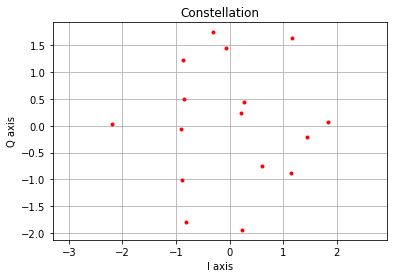

In [15]:
# Plotting the constellation diagram
encoded_planisphere = encoder.predict(eye_matrix) 
plt.title('Constellation')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot(encoded_planisphere[:,0], encoded_planisphere[:,1], 'r.')
plt.grid(True)
plt.axis('equal')
plt.xlabel('I axis')
plt.ylabel('Q axis')

Text(0.5, 0, 'Epoch')

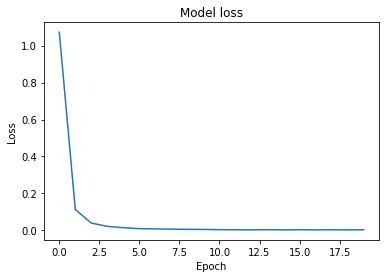

In [16]:
# Plotting the model loss vs. epochs
plt.figure()
plt.plot(hist.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [17]:
# making decoder from full autoencoder
deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [18]:
# Calculating BER from -2dB to 10dB Eb/No

# Generating data of size N
N=100000
test_label = np.random.randint(M,size=N)

# Creating one hot encoded vectors
test_data=[]
for i in test_label:
    temp=np.zeros(M)
    temp[i]=1
    test_data.append(temp)
# Checking data shape
test_data=np.array(test_data)

EbNodB_range = list(np.arange(-2.0,10+1,1))
ber = [None]*len(EbNodB_range)
for n_i in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n_i]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    noise = noise_std*np.random.randn(nn,n)
    encoded_signal = encoder.predict(test_data) 
    final_signal = encoded_signal+noise
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n_i] = no_errors / nn 
    print ('Eb/No:',EbNodB_range[n_i],'BLER:',ber[n_i])

Eb/No: -2.0 BLER: 0.37707
Eb/No: -1.0 BLER: 0.29562
Eb/No: 0.0 BLER: 0.21975
Eb/No: 1.0 BLER: 0.14893
Eb/No: 2.0 BLER: 0.08987
Eb/No: 3.0 BLER: 0.04913
Eb/No: 4.0 BLER: 0.02254
Eb/No: 5.0 BLER: 0.00851
Eb/No: 6.0 BLER: 0.0028
Eb/No: 7.0 BLER: 0.00069
Eb/No: 8.0 BLER: 0.00012
Eb/No: 9.0 BLER: 1e-05
Eb/No: 10.0 BLER: 0.0


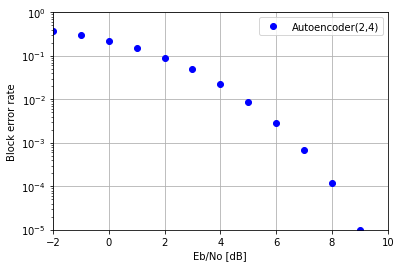

In [19]:
# ploting BER curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(2,4)')
plt.yscale('log')
plt.xlabel('Eb/No [dB]')
plt.ylabel('Block error rate')
plt.grid(True)
plt.legend(loc='upper right',ncol = 1)
plt.ylim(10**-5,1)
plt.xlim(-2,10)
plt.show()